
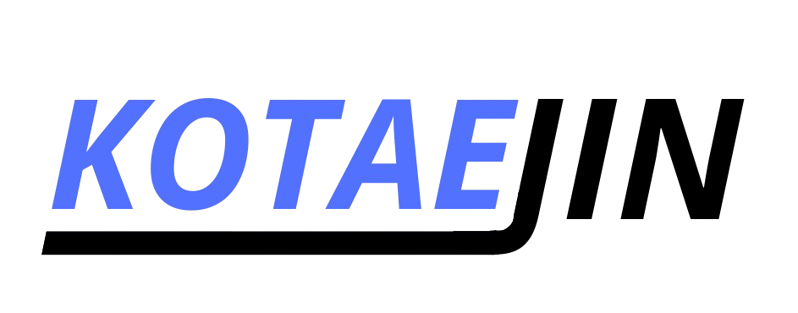

# Sumário

- Descrição do problema
 - Perguntas para serem respondidas utilizando a análise exploratória
- Configurações iniciais
 - Instalando Bibliotecas
 - Realização dos imports
 - Conectando ao google drive
 - Definição de caminhos para a base
- Análise exploratória
 - Definição de funções para a análise exploratória
 - Principais dúvidas do chat
 - Palavras que são mais escritas incorretamente
 - Gírias mais utilizadas pelos clientes
 - Pontuações mais frequentes nas perguntas
 - Bigramas mais frequentes nas respostas ao cliente
- Definição de funções de etapas de pré-processamento
 - Lendo base de dados
 - Treinando tagger floresta
 - Definindo funções para o pré-processamento
 - Testes das funções de pré-processamento
- Uso de Pipeline de pré-processamento
 - Definição da Pipeline
 - Lendo perguntas da base de dados para realização de testes
 - Execução da pipeline
 - Exibição de resultados obtidos
 - Testes de validação de Pipeline
- Bag of Words
 - Definição de função de vetorização Bag of Words (BoW)
 - Testes Bag of Words
- RNN
 - Label Encoder
 - Formatação de Dados Para a Rede Neural
 - Definição do Modelo
 - Compilação do Modelo
 - Early Stop
 - Treinando Modelo
 - Desempenho do Modelo
 - Predição
- Análise Treinamento GPU x CPU
 - Comparação de Resultados

# Descrição do Problema

Conforme descrito no [TAPI](https://drive.google.com/drive/u/1/folders/1N6OswJHbb8QLdlJ9wX9T_IU9zWtTIsNU), dentro do tópico "Esboço do Problema" e do subtópico "Problema", o Serviço de Atendimento ao Cliente (SAC) enfrenta uma demanda elevada, com mais de 25 mil atendimentos mensais realizados via chat online (Live Chat) em múltiplos idiomas. Este volume de solicitações ultrapassa a capacidade de resposta dos atendentes humanos, resultando em atrasos no atendimento e gerando insatisfação entre os clientes.

De acordo com o subtópico "Objetivo" no [TAPI](https://drive.google.com/drive/u/1/folders/1N6OswJHbb8QLdlJ9wX9T_IU9zWtTIsNU), para enfrentar este desafio, será desenvolvido um chatbot utilizando modelos abertos de IA Generativa, com foco no atendimento ao cliente. Este chatbot será gerido por um grupo de usuários internos, que poderão criar, operar e personalizar o sistema de forma contínua. Durante o projeto, um desenvolvedor da Brastel, localizado no Brasil, será designado para colaborar no desenvolvimento, garantindo que os protótipos desenvolvidos possam ser efetivamente utilizados na construção do sistema final.


### Perguntas para Análise Exploratória

1. **Em qual período do dia o chat recebe mais acessos?**
   - **Propósito:** Entender os momentos de pico de uso do chat ao longo do dia é essencial para planejar a escalabilidade do sistema e prevenir possíveis congestionamentos devido ao alto número de acessos simultâneos.

2. **Quais são as dúvidas mais frequentes entre os usuários?**
   - **Propósito:** Identificar as dúvidas mais comuns permite configurar respostas pré-definidas no chatbot, otimizando o tempo de resposta e reduzindo o processamento desnecessário.

3. **Qual é a proporção de palavras recorrentes escritas de maneira incorreta?**
   - **Propósito:** Avaliar a frequência de erros ortográficos comuns ajuda a treinar o modelo para reconhecer e interpretar corretamente essas variações, melhorando a eficiência do chatbot.

4. **As mensagens contêm muitas gírias ou abreviações?**
   - **Propósito:** Analisar o uso de gírias e abreviações nas mensagens é importante, pois o modelo precisa ser treinado para entender esses termos. Identificar as mais comuns auxilia no treinamento para aumentar a precisão do chatbot.

5. **O uso de pontuação é frequente nas mensagens?**
   - **Propósito:** Compreender o padrão de uso de pontuação nas mensagens ajuda a entender o estilo de comunicação dos usuários. A pontuação pode mudar o sentido das frases, transformando uma afirmação em uma pergunta, por exemplo, o que é crítico para a interpretação correta pelo chatbot.

6. **As respostas dos usuários seguem algum padrão específico?**
   - **Propósito:** Identificar padrões nas respostas pode revelar se há uma repetição significativa de perguntas ou respostas, o que pode ser utilizado para otimizar as interações e treinamentos do chatbot.


#Configurações Iniciais

In [157]:
DOWNLOAD_DF = False
DOWNLOAD_DF_NUMERIC = False
DOWNLOAD_MODEL = True

## Instalando Bibliotecas

In [158]:
!pip install spacy
!python -m spacy download pt_core_news_sm
!pip install -U scikit-learn
!pip install openpyxl
!pip install pyspellchecker
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Realização dos imports


Nesta etapa, o colab é preparado com a instalação e importação de bibliotecas e pacotes necessários para a execução do projeto.

In [159]:
import nltk
import random
import re
import spacy
import string
import time
import unittest

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from collections import Counter, defaultdict
from google.colab import files
from IPython.display import display

from nltk.corpus import stopwords, floresta
from nltk.stem import PorterStemmer, SnowballStemmer, RSLPStemmer, WordNetLemmatizer
from nltk.tag import pos_tag, UnigramTagger
from nltk.tokenize import sent_tokenize, word_tokenize

from spellchecker import SpellChecker
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Layer, SimpleRNN, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam



nltk.download('averaged_perceptron_tagger')
nltk.download('floresta')
nltk.download('maxent_ne_chunker')
nlp = spacy.load("pt_core_news_sm")
nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   

True

## Conectando ao google drive

In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definição de caminhos para a base

In [161]:
DEFAULT_XLS_PATH = "/content/drive/MyDrive/m11/data/chat_clients.xlsx"
DEFAULT_CSV_PATH = "/content/drive/MyDrive/m11/data/augmented_data.csv"

def get_file_paths():
    xls_path = input(f"Digite o caminho do arquivo Excel (ou pressione Enter para usar o caminho padrão): ")
    xls_path = xls_path if xls_path.strip() else DEFAULT_XLS_PATH

    csv_path = input(f"Digite o caminho do arquivo CSV (ou pressione Enter para usar o caminho padrão): ")
    csv_path = csv_path if csv_path.strip() else DEFAULT_CSV_PATH

    return xls_path, csv_path

XLS_PATH, CSV_PATH = get_file_paths()

Digite o caminho do arquivo Excel (ou pressione Enter para usar o caminho padrão): 
Digite o caminho do arquivo CSV (ou pressione Enter para usar o caminho padrão): 


#Análise exploratória

## Definição de funções para a análise exploratória

In [162]:
def remocao_stopword(text):
    stop_words = set(stopwords.words('portuguese'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def conversao_minuscula(text):
    try:
        text = text.lower()
    except:
        pass
    return text

def encontrar_erros(texto):
    spell = SpellChecker(language='pt')
    palavras = texto.split()
    palavras_erradas = spell.unknown(palavras)
    return palavras_erradas

def limpar_sentenca(sentence: str) -> str:
    cleaned_sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
    return cleaned_sentence

def verificar_giras_abreviacoes(texto, giras_abreviacoes):
    palavras = texto.lower().split()
    giras_encontradas = [palavra for palavra in palavras if palavra in giras_abreviacoes]
    return giras_encontradas

def contar_pontuacoes(texto):
    pontuacoes = re.findall(r'[^\w\s]', texto)
    return pontuacoes

def encontrar_bigramas(texto):
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform([texto])
    bigramas = vectorizer.get_feature_names_out()
    frequencias = bag_of_words.toarray().sum(axis=0)
    return dict(zip(bigramas, frequencias))

In [163]:
df_filtrado = pd.read_excel(XLS_PATH)[['Intencao', 'Pergunta', 'Resposta\n']]
df_filtrado.rename(columns={'Resposta\n': 'Resposta'}, inplace=True)

df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(limpar_sentenca)
df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(remocao_stopword)
df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(conversao_minuscula)
df_filtrado['Intencao'] = df_filtrado['Intencao'].apply(conversao_minuscula)
df_filtrado['Resposta'] = df_filtrado['Resposta'].apply(conversao_minuscula)


df_filtrado

,Intencao,Pergunta,Resposta
0,como depositar,boa diatudo bemeu gostaria saber sobre caixa f...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,como fazer remessa,como enviar dinheiro japo,"para se inscrever no serviço de remessa, por f..."
2,tempo de remessa,quanto tempo levar beneficirio receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,"pedido de envio via metodo ""byphone""",boa tarde acabei fazer transferncia 2223 total...,iremos processar a sua solicitacao.\nmuito obr...
4,"pedido de envio via metodo ""byphone""",poderia fazer remessa 22yenes bbb rrr obrigado...,iremos processar a sua solicitacao.\nmuito obr...
...,...,...,...
500,atualizacao de dados cadastrais,boa tarde fao fazer mudana endereo,a senhora pode trocar pelo próprio app da bras...
501,tempo de entrega do cartao,bom dia consegui fazer depsito carto ainda che...,boa noite\no sr solicitou dia 28. será entregu...
502,cancelamento,boa noitea beneficiria avisou conta est errado...,"sim, podemos cancelar\no valor voltará no seu ..."
503,reembolso,boa noite eu fiz depsito errado pra depositar ...,é possível solicitar o reembolso diretamente d...


## Principais dúvidas do chat

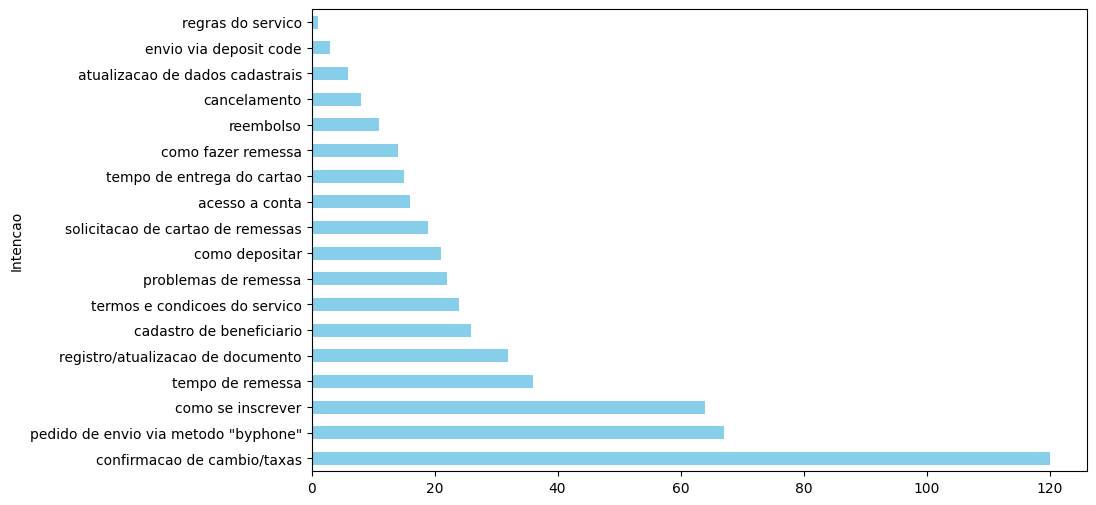

In [164]:
contagem = df_filtrado['Intencao'].value_counts()
plt.figure(figsize=(10, 6))
contagem.plot(kind='barh', color='skyblue')

plt.show()

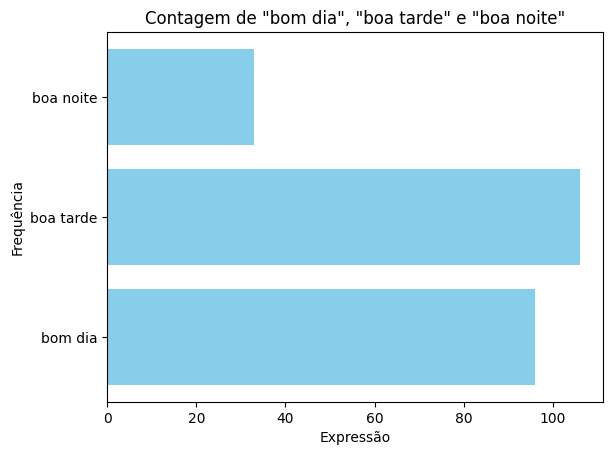

In [165]:
data = {
    'mensagens': [
        'bom dia',
        'boa tarde',
        'boa noite'
    ]
}

df = pd.DataFrame(data)

contagem = {
    'bom dia': df_filtrado['Pergunta'].str.contains('bom dia', case=False).sum(),
    'boa tarde': df_filtrado['Pergunta'].str.contains('boa tarde', case=False).sum(),
    'boa noite': df_filtrado['Pergunta'].str.contains('boa noite', case=False).sum()
}

plt.barh(list(contagem.keys()), list(contagem.values()), color=['skyblue'])
plt.xlabel('Expressão')
plt.ylabel('Frequência')
plt.title('Contagem de "bom dia", "boa tarde" e "boa noite"')
plt.show()

## Palavras que são mais escritas incorretamente

In [166]:
spell = SpellChecker(language='pt')
stop_words = set(stopwords.words('portuguese'))


def preprocessar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

def encontrar_erros(texto):
    texto = preprocessar_texto(texto)
    palavras = texto.split()
    erros = [palavra for palavra in palavras if palavra not in stop_words and palavra not in spell]
    return erros

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80')])

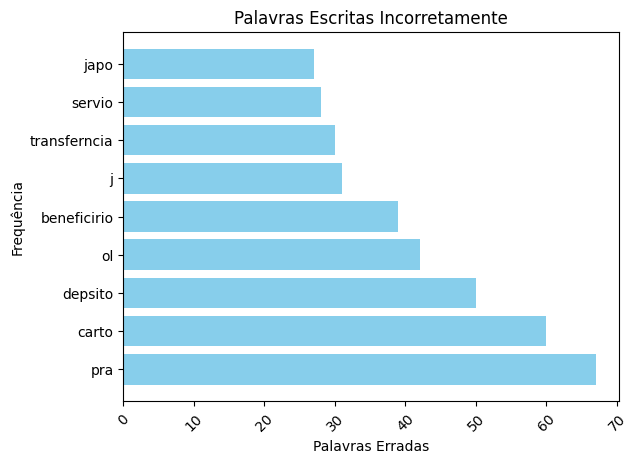

In [167]:
df_filtrado['erros'] = df_filtrado['Pergunta'].apply(lambda x: encontrar_erros(x))
todos_erros = [erro for sublist in df_filtrado['erros'] for erro in sublist]
contagem_erros = Counter(todos_erros)
top_erros = contagem_erros.most_common(10)[1:]
palavras, frequencias = zip(*top_erros)
plt.barh(list(palavras), list(frequencias), color='skyblue')
plt.xlabel('Palavras Erradas')
plt.ylabel('Frequência')
plt.title('Palavras Escritas Incorretamente')
plt.xticks(rotation=45)

## Gírias mais utilizadas pelos clientes

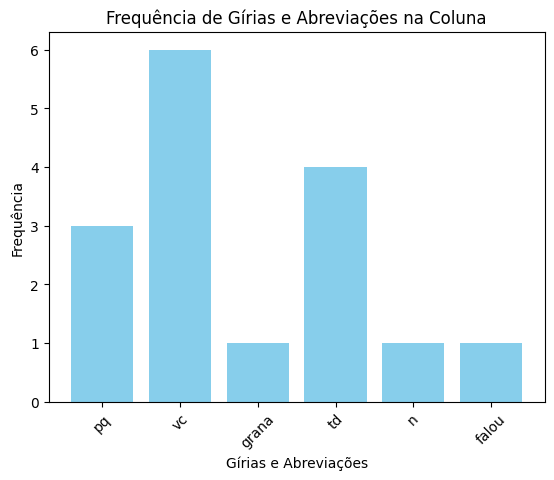

In [168]:
giras_abreviacoes = [
    "rolê", "zoar", "dahora", "massa", "mano", "man", "bicho", "treta", "falou",
    "sussa", "balada", "perifa", "bagulho", "cabuloso", "grana", "leco",
    "vc", "tb", "blz", "qnd", "pq", "ctz", "fds", "tbm", "mt", "flw", "n",
    "td", "tlg", "tá", "lol", "brb", "omg", "btw", "asap"
]

df_filtrado['giras_encontradas'] = df_filtrado['Pergunta'].apply(lambda x: verificar_giras_abreviacoes(x, giras_abreviacoes))

todos_giras = [giria for sublist in df_filtrado['giras_encontradas'] for giria in sublist]
contagem_giras = Counter(todos_giras)

plt.bar(contagem_giras.keys(), contagem_giras.values(), color='skyblue')
plt.xlabel('Gírias e Abreviações')
plt.ylabel('Frequência')
plt.title('Frequência de Gírias e Abreviações na Coluna')
plt.xticks(rotation=45)
plt.show()

## Pontuações mais frequentes nas perguntas

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


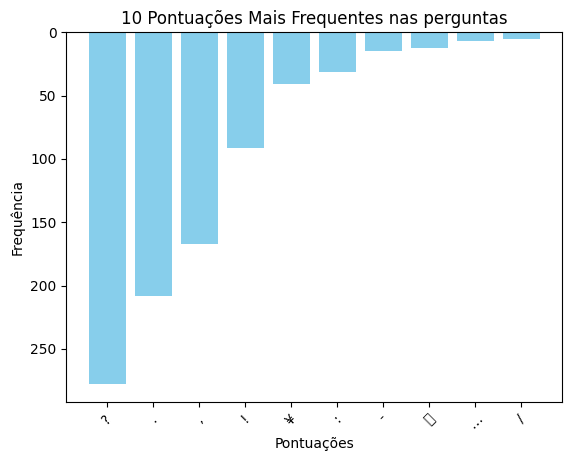

In [169]:
df = pd.read_excel(XLS_PATH)[['Intencao', 'Pergunta', 'Resposta\n']]

df['pontuacoes'] = df['Pergunta'].apply(contar_pontuacoes)

todas_pontuacoes = [ponto for sublist in df['pontuacoes'] for ponto in sublist]
contagem_pontuacoes = Counter(todas_pontuacoes)

top_10_pontuacoes = contagem_pontuacoes.most_common(10)

pontuacoes, frequencias = zip(*top_10_pontuacoes)

plt.bar(pontuacoes, frequencias, color='skyblue')
plt.xlabel('Pontuações')
plt.ylabel('Frequência')
plt.title('10 Pontuações Mais Frequentes nas perguntas')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()

plt.show()

## Bigramas mais frequentes nas respostas ao cliente

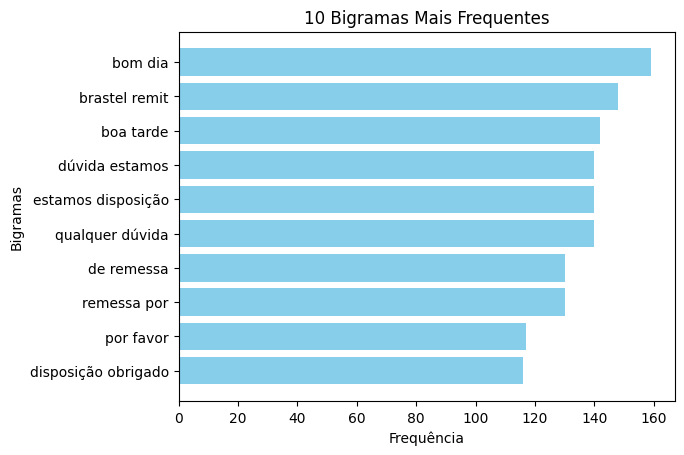

In [170]:
df['Resposta\n'] = df['Resposta\n'].fillna('')

todos_bigramas = Counter()
for texto in df['Resposta\n']:
    try:
        bigramas = encontrar_bigramas(texto)
        todos_bigramas.update(bigramas)
    except:
        pass

top_10_bigramas = todos_bigramas.most_common(10)

bigramas, frequencias = zip(*top_10_bigramas)

plt.barh(bigramas, frequencias, color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Bigramas')
plt.title('10 Bigramas Mais Frequentes')
plt.gca().invert_yaxis()
plt.show()

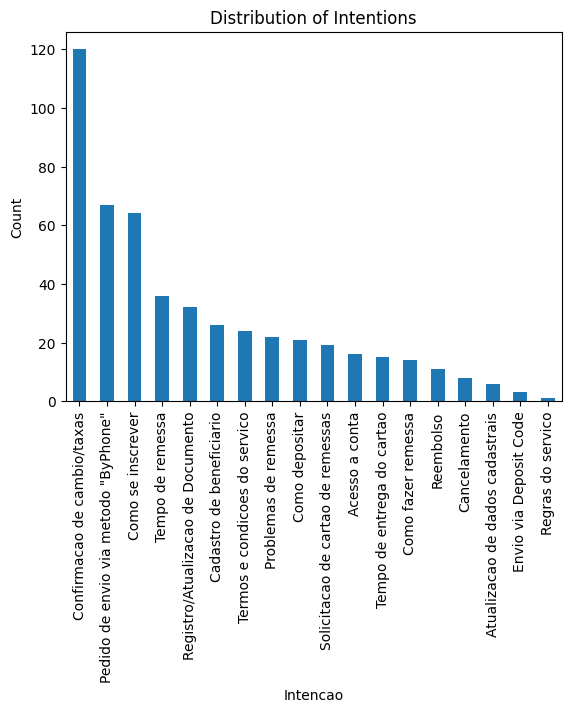

In [171]:
import matplotlib.pyplot as plt

df['Intencao'].value_counts().plot(kind='bar')
plt.xlabel('Intencao')
plt.ylabel('Count')
_ = plt.title('Distribution of Intentions')

#Definição de funções de etapas de pré-processamento

## lendo base de dados

In [172]:
file_path = CSV_PATH
headers = ["numero", "intencao", "pergunta", "resposta"]
csv_words = pd.read_csv(file_path)
csv_words.shape

(2615, 2)

In [173]:
csv_words = csv_words.dropna().reset_index(drop=True)

csv_words.shape

(2609, 2)

In [174]:
csv_words = csv_words.apply(lambda x: x.str.replace("\n", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\t", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\r", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\f", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\v", " ", regex=False) if x.dtype == "object" else x)

In [175]:
print(df.shape)
csv_words.head()

(505, 4)


,Intencao,Pergunta
0,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...
1,Como fazer remessa,Como enviar dinheiro do Japão?
2,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...
3,"Pedido de envio via metodo ""ByPhone""",Boa tarde Acabei de fazer a transferência de 2...
4,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...


## Definindo funções para o pré-processamento

In [176]:
import spacy
import string

nlp = spacy.load('pt_core_news_sm')

def segmentar(texto):
    """Segmenta o texto em sentenças."""
    doc = nlp(texto)
    return [sent.text for sent in doc.sents]

def tokenizar(texto):
    """Tokeniza o texto em palavras."""
    doc = nlp(texto)
    return [token.text for token in doc]

def lematizar(tokens):
    """Lemmatiza tokens usando spaCy."""
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def stemming(tokens):
    """Aplica stemming aos tokens usando spaCy (não há stemming nativo, mas podemos usar lematização)."""
    return lematizar(tokens)  # SpaCy não tem um stemmer, então usamos lematização.

def remover_stopwords(tokens):
    """Remove stopwords dos tokens."""
    stop_words = set(nlp.Defaults.stop_words)
    return [word for word in tokens if word.lower() not in stop_words]

def pos_tagging(tokens):
    """Realiza POS tagging nos tokens usando spaCy."""
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

def remover_pontuacao(tokens):
    """Remove pontuação dos tokens."""
    return [token for token in tokens if token not in string.punctuation]

def reconhecimento_entidades_nomeadas(tokens):
    """Reconhece entidades nomeadas nos tokens usando spaCy."""
    doc = nlp(" ".join(tokens))
    return [(ent.text, ent.label_) for ent in doc.ents]


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


## Testes das funções de pré-processamento

In [177]:
# Texto de exemplo
texto = "O Leandro comprou um carro novo. Ele está muito feliz com a nova aquisição!"

In [178]:
# Teste da função segmentar
resultado_esperado_segmentar = ['O Leandro comprou um carro novo.', 'Ele está muito feliz com a nova aquisição!']
resultado_obtido_segmentar = segmentar(texto)
assert resultado_obtido_segmentar == resultado_esperado_segmentar, f"Erro no teste de segmentação. Esperado: {resultado_esperado_segmentar}, Obtido: {resultado_obtido_segmentar}"
print("Teste de segmentação passou!")

Teste de segmentação passou!


In [179]:
# Teste da função tokenizar
resultado_esperado_tokenizar = ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo', '.', 'Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição', '!']
resultado_obtido_tokenizar = tokenizar(texto)
assert resultado_obtido_tokenizar == resultado_esperado_tokenizar, f"Erro no teste de tokenização. Esperado: {resultado_esperado_tokenizar}, Obtido: {resultado_obtido_tokenizar}"
print("Teste de tokenização passou!")

Teste de tokenização passou!


In [180]:
# Teste da função lematizar
tokens_exemplo = ['Leandro', 'comprou', 'carros']
resultado_esperado_lematizar = ['Leandro', 'comprar', 'carro']
resultado_obtido_lematizar = lematizar(tokens_exemplo)
assert resultado_obtido_lematizar == resultado_esperado_lematizar, f"Erro no teste de lematização. Esperado: {resultado_esperado_lematizar}, Obtido: {resultado_obtido_lematizar}"
print("Teste de lematização passou!")

Teste de lematização passou!


In [181]:
# Teste da função stemming
resultado_esperado_stemming = ['Leandro', 'comprar', 'carro']
resultado_obtido_stemming = stemming(tokens_exemplo)
assert resultado_obtido_stemming == resultado_esperado_stemming, f"Erro no teste de stemming. Esperado: {resultado_esperado_stemming}, Obtido: {resultado_obtido_stemming}"
print("Teste de stemming passou!")

Teste de stemming passou!


In [182]:
# Teste da função remover_stopwords
resultado_esperado_remover_stopwords = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_stopwords = remover_stopwords(tokens_exemplo)
assert resultado_obtido_remover_stopwords == resultado_esperado_remover_stopwords, f"Erro no teste de remoção de stopwords. Esperado: {resultado_esperado_remover_stopwords}, Obtido: {resultado_obtido_remover_stopwords}"
print("Teste de remoção de stopwords passou!")

Teste de remoção de stopwords passou!


In [183]:
# Teste da função pos_tagging
resultado_esperado_pos_tagging = [('Leandro', 'PROPN'), ('comprou', 'VERB'), ('carros', 'NOUN')]
resultado_obtido_pos_tagging = pos_tagging(tokens_exemplo)
assert resultado_obtido_pos_tagging == resultado_esperado_pos_tagging, f"Erro no teste de POS tagging. Esperado: {resultado_esperado_pos_tagging}, Obtido: {resultado_obtido_pos_tagging}"
print("Teste de POS tagging passou!")

Teste de POS tagging passou!


In [184]:
# Teste da função remover_pontuacao
tokens_com_pontuacao = ['Leandro', ',', 'comprou', 'carros', '.']
resultado_esperado_remover_pontuacao = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_pontuacao = remover_pontuacao(tokens_com_pontuacao)
assert resultado_obtido_remover_pontuacao == resultado_esperado_remover_pontuacao, f"Erro no teste de remoção de pontuação. Esperado: {resultado_esperado_remover_pontuacao}, Obtido: {resultado_obtido_remover_pontuacao}"
print("Teste de remoção de pontuação passou!")

Teste de remoção de pontuação passou!


In [185]:
# Teste da função reconhecimento_entidades_nomeadas
resultado_esperado_reconhecimento_entidades = [('Leandro', 'PER')]
resultado_obtido_reconhecimento_entidades = reconhecimento_entidades_nomeadas(tokens_exemplo)
assert resultado_obtido_reconhecimento_entidades == resultado_esperado_reconhecimento_entidades, f"Erro no teste de reconhecimento de entidades nomeadas. Esperado: {resultado_esperado_reconhecimento_entidades}, Obtido: {resultado_obtido_reconhecimento_entidades}"
print("Teste de reconhecimento de entidades nomeadas passou!")

Teste de reconhecimento de entidades nomeadas passou!


#Uso de Pipeline de pré-processamento

## Definição da Pipeline

In [186]:
def pipeline_preprocessamento(texto, intencao, aplicar_segmentacao=True, aplicar_tokenizacao=True, aplicar_lematizacao=True,
                              aplicar_stemming=True, aplicar_remocao_stopwords=True, aplicar_pos_tagging=True,
                              aplicar_reconhecimento_entidades=True, aplicar_remocao_pontuacao=True):

    used_random_numbers = set()

    resultados = []

    sentencaIndex = 0
    for sentenca in texto:

        output = {'Sentenca Original': sentenca}

        if aplicar_tokenizacao:
            tokens = tokenizar(sentenca)

        if aplicar_lematizacao:
            tokens = lematizar(tokens)

        if aplicar_reconhecimento_entidades:
            entidades = reconhecimento_entidades_nomeadas(tokens)
            named_entity_tokens = {entity[0] for entity in entidades}
        else:
            named_entity_tokens = set()

        if aplicar_remocao_pontuacao:
            tokens = remover_pontuacao(tokens)

        if aplicar_remocao_stopwords:
            tokens = remover_stopwords(tokens)

        if aplicar_pos_tagging:
            pos_tags = pos_tagging(tokens)
            pos_tag_dict = {word: tag for word, tag in pos_tags}
        else:
            pos_tag_dict = {}

        if aplicar_stemming:
            stemmed_tokens = stemming(tokens)

        sentence_counter = Counter(tokens)

        seen_tokens = set()
        combined_info = []
        for stem, token in zip(stemmed_tokens, tokens):
            if token not in seen_tokens:
                seen_tokens.add(token)
                is_named = True if token in named_entity_tokens else False
                pos = pos_tag_dict.get(token, "None")
                sentence_count = sentence_counter[token]


                combined_info.append([stem, is_named, pos, sentence_count, sentencaIndex, intencao[sentencaIndex]])

        sentencaIndex = sentencaIndex + 1
        output['words'] = combined_info
        resultados.append(output)

    return resultados

## Lendo perguntas da base de dados para realização de testes

In [187]:
csv_words.columns


Index(['Intencao', 'Pergunta'], dtype='object')

In [188]:
csv_words['Pergunta'].head()

,Pergunta
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...
1,Como enviar dinheiro do Japão?
2,Quanto tempo levará para o beneficiário recebe...
3,Boa tarde Acabei de fazer a transferência de 2...
4,Poderia fazer a remessa de 22yenes para o BBB ...


## Execução da pipeline

In [189]:
csv_words.iloc[630:680]

,Intencao,Pergunta
630,Termos e condicoes do servico,Como eu faço pra depositar do meu cartão pra c...
631,Problemas/Duvidas sobre deposito,"Bom dia, não consegui depositar dinheiro usand..."
632,Tempo de entrega do cartao,sim Presciso do cartão verde
633,Cadastro de beneficiario,O dígito final está diferente estranho q fiz v...
634,Problemas/Duvidas de atualizacao de dados cada...,"Bom dia , estou recebendo uma mensagem que meu..."
635,"Pedido de envio via metodo ""ByPhone""",Bom dia! Após a confirmação do meu depósito qu...
636,Problemas/Duvidas sobre remessas,ola boa tarde entao eu fiz uma remessa de gran...
637,Problemas/Duvidas de atualizacao de dados cada...,Recebi uma mensagem para reenviar frente e ver...
638,Problemas/Duvidas sobre remessas,Eu enviei um dinheiro mas ainda não caiu na co...
639,Problemas/Duvidas sobre remessas,Brastel dá para mandar pix


In [190]:
resultados = pipeline_preprocessamento(csv_words["Pergunta"], csv_words["Intencao"])

df_resultados = pd.DataFrame(resultados)

df_resultados

,Sentenca Original,words
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"[[dia.tudo, False, ADJ, 1, 0, Como depositar],..."
1,Como enviar dinheiro do Japão?,"[[enviar, False, VERB, 1, 1, Como fazer remess..."
2,Quanto tempo levará para o beneficiário recebe...,"[[levar, False, VERB, 1, 2, Tempo de remessa],..."
3,Boa tarde Acabei de fazer a transferência de 2...,"[[Acabei, True, PROPN, 1, 3, Pedido de envio v..."
4,Poderia fazer a remessa de 22yenes para o BBB ...,"[[poderiar, False, VERB, 1, 4, Pedido de envio..."
...,...,...
2604,"1. Recebi o aplicativo, porém ele não inicia a...","[[1, False, NUM, 1, 2604, Dificuldades com uti..."
2605,"1. 'Recebi o aplicativo, porém ele não inicia ...","[[1, False, NUM, 1, 2605, Dificuldades com uti..."
2606,"1. Recebi o aplicativo, porém ele não inicia a...","[[1, False, NUM, 1, 2606, Dificuldades com uti..."
2607,"1. Recebi o aplicativo, porém ele não inicia a...","[[1, False, NUM, 1, 2607, Dificuldades com uti..."


## Exibição de resultados obtidos

In [191]:
resultados

[{'Sentenca Original': 'Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado',
  'words': [['dia.tudo', False, 'ADJ', 1, 0, 'Como depositar'],
   ['bem?eu', False, 'ADJ', 1, 0, 'Como depositar'],
   ['gostar', False, 'VERB', 1, 0, 'Como depositar'],
   ['caixa', False, 'NOUN', 1, 0, 'Como depositar'],
   ['de', False, 'None', 1, 0, 'Como depositar'],
   ['o', False, 'NOUN', 1, 0, 'Como depositar'],
   ['family', False, 'PROPN', 1, 0, 'Como depositar'],
   ['Mart', False, 'ADJ', 1, 0, 'Como depositar'],
   ['verde', False, 'ADP', 1, 0, 'Como depositar'],
   ['eh', False, 'NUM', 1, 0, 'Como depositar'],
   ['24', True, 'PROPN', 1, 0, 'Como depositar'],
   ['horas?e', False, 'VERB', 1, 0, 'Como depositar'],
   ['transferir', False, 'VERB', 1, 0, 'Como depositar']]},
 {'Sentenca Original': 'Como enviar dinheiro do Japão?',
  'words': [['enviar', False, 'VERB', 1, 1, 'Como fazer remessa'],
   ['dinheiro',

In [192]:
for resultado in resultados[:5]:
    print(f"Sentence: {resultado['Sentenca Original']}")
    print("Words:")
    for word_info in resultado['words']:
        print(word_info)
    print("____________________________________________________________________________________________________")

Sentence: Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado
Words:
['dia.tudo', False, 'ADJ', 1, 0, 'Como depositar']
['bem?eu', False, 'ADJ', 1, 0, 'Como depositar']
['gostar', False, 'VERB', 1, 0, 'Como depositar']
['caixa', False, 'NOUN', 1, 0, 'Como depositar']
['de', False, 'None', 1, 0, 'Como depositar']
['o', False, 'NOUN', 1, 0, 'Como depositar']
['family', False, 'PROPN', 1, 0, 'Como depositar']
['Mart', False, 'ADJ', 1, 0, 'Como depositar']
['verde', False, 'ADP', 1, 0, 'Como depositar']
['eh', False, 'NUM', 1, 0, 'Como depositar']
['24', True, 'PROPN', 1, 0, 'Como depositar']
['horas?e', False, 'VERB', 1, 0, 'Como depositar']
['transferir', False, 'VERB', 1, 0, 'Como depositar']
____________________________________________________________________________________________________
Sentence: Como enviar dinheiro do Japão?
Words:
['enviar', False, 'VERB', 1, 1, 'Como fazer remessa']
['dinhei

In [193]:
data = []
for resultado in resultados:
    sentence = resultado['Sentenca Original']
    for word_info in resultado['words']:
        data.append({
            'Sentenca Original': sentence,
            'stemmed': word_info[0],
            'ent_nomeada': word_info[1],
            'pos_tagging': word_info[2],
            'ocorrencias': word_info[3],
            'id_sentenca': word_info[4],
            'intencao': word_info[5]
        })

df = pd.DataFrame(data)

display(df)

,Sentenca Original,stemmed,ent_nomeada,pos_tagging,ocorrencias,id_sentenca,intencao
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,dia.tudo,False,ADJ,1,0,Como depositar
1,Boa dia.tudo bem?eu gostaria de saber sobre aq...,bem?eu,False,ADJ,1,0,Como depositar
2,Boa dia.tudo bem?eu gostaria de saber sobre aq...,gostar,False,VERB,1,0,Como depositar
3,Boa dia.tudo bem?eu gostaria de saber sobre aq...,caixa,False,NOUN,1,0,Como depositar
4,Boa dia.tudo bem?eu gostaria de saber sobre aq...,de,False,None,1,0,Como depositar
...,...,...,...,...,...,...,...
43840,"1. Recebi o aplicativo, porém ele não inicia a...",antigo,False,ADJ,1,2608,Dificuldades com utilizacao do App
43841,"1. Recebi o aplicativo, porém ele não inicia a...",mostrar,False,VERB,1,2608,Dificuldades com utilizacao do App
43842,"1. Recebi o aplicativo, porém ele não inicia a...",seguir,False,VERB,1,2608,Dificuldades com utilizacao do App
43843,"1. Recebi o aplicativo, porém ele não inicia a...",3,False,NUM,1,2608,Dificuldades com utilizacao do App


In [194]:
df.describe()

,ocorrencias,id_sentenca
count,43845.000000,43845.000000
mean,1.411837,1478.690957
std,0.909464,675.061862
min,1.000000,0.000000
25%,1.000000,959.000000
50%,1.000000,1512.000000
75%,1.000000,2034.000000
max,10.000000,2608.000000


In [195]:
df.columns

Index(['Sentenca Original', 'stemmed', 'ent_nomeada', 'pos_tagging',
       'ocorrencias', 'id_sentenca', 'intencao'],
      dtype='object')

In [196]:
df['intencao'].unique()

array(['Como depositar', 'Como fazer remessa', 'Tempo de remessa',
       'Pedido de envio via metodo "ByPhone"', 'Como se inscrever',
       'Confirmacao de cambio/taxas', 'Envio via Deposit Code',
       'Registro/Atualizacao de Documento',
       'Solicitacao de cartao de remessas', 'Cadastro de beneficiario',
       'Acesso a conta', 'Termos e condicoes do servico',
       'Problemas de remessa', 'Tempo de entrega do cartao', 'Reembolso',
       'Regras do servico', 'Atualizacao de dados cadastrais',
       'Cancelamento', 'Problemas/Duvidas sobre deposito',
       'Problemas/Duvidas de atualizacao de dados cadastrais',
       'Problemas/Duvidas sobre remessas',
       'Dificuldades com utilizacao do App'], dtype=object)

In [197]:
df_copy = df.copy()

In [198]:
if DOWNLOAD_DF:
  df.to_csv('my_data.csv', index=False)

  files.download('my_data.csv')

## Testes de validação de Pipeline

In [199]:
def validate_word_info(word_info):
    """
    Este teste tem como objetivo realizar a validação dos arrays de resposta obtidos na pipe

    resultados esperados [String, Boolean, String, Int, Int]
    """
    if len(word_info) != 6:
        print(f"Tamanho de resposta errado: {word_info}")
        return False

    if not isinstance(word_info[0], str):
        print(f"Elemento de índice '0' deve ser do tipo 'String': {word_info}")
        return False

    if not isinstance(word_info[1], bool):
        print(f"Elemento de índice '1' deve ser do tipo 'Boolean': {word_info}")
        return False

    if not (word_info[2] is None or isinstance(word_info[2], str)):
        print(f"Elemento de índice '2' deve ser do tipo 'String: {word_info}")
        return False

    if not isinstance(word_info[3], int):
        print(f"Elemento de índice '3' deve ser do tipo 'Integer': {word_info}")
        return False

    if not isinstance(word_info[4], int):
        print(f"Elemento de índice '4' deve ser do tipo 'Integer': {word_info}")
        return False

    if not isinstance(word_info[5], str):
        print(f"Elemento de índice '5' deve ser do tipo 'String': {word_info}")
        return False

    return True

def validate_results(resultados):
    all_valid = True
    for resultado in resultados:
        for word_info in resultado['words']:
            if not validate_word_info(word_info):
                all_valid = False
    return all_valid

is_valid = validate_results(resultados)
print(f"Os arrays são válidos? {is_valid}")


Os arrays são válidos? True


In [200]:
def testar_pipeline():
    """
    Este teste tem como objetivo a comparação entre resultados obtidos e esperados na execução da pipeline.
    """

    INPUT = ["O Leandro comprou um carro novo.", "Ele está muito feliz com a nova aquisição!"]
    INTENCAO = ["compra", "felicidade"]

    # Somente os campos estáveis são incluídos no resultado esperado
    result_esperado = [
        [
            ['Leandro', True, 'PROPN', 1],
            ['comprar', False, 'VERB', 1],
            ['carro', False, 'NOUN', 1],
        ],
        [
            ['feliz', False, 'ADJ', 1],
            ['aquisição', False, 'NOUN', 1]
        ]
    ]

    result_obtido = pipeline_preprocessamento(INPUT, INTENCAO)

    sucesso = True

    result_obtido = pipeline_preprocessamento(INPUT, INTENCAO)

    sucesso = True

    print("🤖 Iniciando testes de pipeline... 🤖")
    print("____________________________________________________________________________________________________")

    print("Resultados obtidos:")
    for i, r in enumerate(result_obtido):
        print(f"Sentença {i}: {r}")

    # Compare apenas quando result_obtido e result_esperado têm a mesma estrutura
    for s_idx in range(len(result_obtido)):
        if s_idx < len(result_esperado):
            for i in range(len(result_obtido[s_idx]['words'])):
                try:
                    obtido = result_obtido[s_idx]['words'][i][:4]  # Pegando os primeiros quatro elementos
                    esperado = result_esperado[s_idx][i]
                    print(f"Comparando: obtido='{obtido}', esperado='{esperado}'")
                    assert obtido == esperado
                    print("✅")
                except AssertionError:
                    print("❌")
                    sucesso = False
                except IndexError:
                    print(f"❌ Índice fora do intervalo para a sentença {s_idx} e índice {i}.")
                    sucesso = False
                print("____________________________________________________________________________________________________")

    if sucesso:
        print("👍 Todos os testes passaram!")
    else:
        print("👎 Teste falhou!")

testar_pipeline()



🤖 Iniciando testes de pipeline... 🤖
____________________________________________________________________________________________________
Resultados obtidos:
Sentença 0: {'Sentenca Original': 'O Leandro comprou um carro novo.', 'words': [['Leandro', True, 'PROPN', 1, 0, 'compra'], ['comprar', False, 'VERB', 1, 0, 'compra'], ['carro', False, 'NOUN', 1, 0, 'compra']]}
Sentença 1: {'Sentenca Original': 'Ele está muito feliz com a nova aquisição!', 'words': [['feliz', False, 'ADJ', 1, 1, 'felicidade'], ['aquisição', False, 'NOUN', 1, 1, 'felicidade']]}
Comparando: obtido='['Leandro', True, 'PROPN', 1]', esperado='['Leandro', True, 'PROPN', 1]'
✅
____________________________________________________________________________________________________
Comparando: obtido='['comprar', False, 'VERB', 1]', esperado='['comprar', False, 'VERB', 1]'
✅
____________________________________________________________________________________________________
Comparando: obtido='['carro', False, 'NOUN', 1]', espe

In [201]:
# Inicialização variável de contagem do tempo para CPU ou GPU
start_time = time.time()

# Bag of Words

## Definição de função de vetorização Bag of Words (BoW)

In [202]:
df.head()

,Sentenca Original,stemmed,ent_nomeada,pos_tagging,ocorrencias,id_sentenca,intencao
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,dia.tudo,False,ADJ,1,0,Como depositar
1,Boa dia.tudo bem?eu gostaria de saber sobre aq...,bem?eu,False,ADJ,1,0,Como depositar
2,Boa dia.tudo bem?eu gostaria de saber sobre aq...,gostar,False,VERB,1,0,Como depositar
3,Boa dia.tudo bem?eu gostaria de saber sobre aq...,caixa,False,NOUN,1,0,Como depositar
4,Boa dia.tudo bem?eu gostaria de saber sobre aq...,de,False,None,1,0,Como depositar


In [203]:
df.columns

Index(['Sentenca Original', 'stemmed', 'ent_nomeada', 'pos_tagging',
       'ocorrencias', 'id_sentenca', 'intencao'],
      dtype='object')

In [204]:
if 'intencao' in df.columns:
    num_intencoes_diferentes = df['intencao'].nunique()
    print(f"Número de intenções diferentes: {num_intencoes_diferentes}")
else:
    print("Coluna 'intencao' não encontrada no DataFrame.")


Número de intenções diferentes: 22


In [205]:
df

,Sentenca Original,stemmed,ent_nomeada,pos_tagging,ocorrencias,id_sentenca,intencao
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,dia.tudo,False,ADJ,1,0,Como depositar
1,Boa dia.tudo bem?eu gostaria de saber sobre aq...,bem?eu,False,ADJ,1,0,Como depositar
2,Boa dia.tudo bem?eu gostaria de saber sobre aq...,gostar,False,VERB,1,0,Como depositar
3,Boa dia.tudo bem?eu gostaria de saber sobre aq...,caixa,False,NOUN,1,0,Como depositar
4,Boa dia.tudo bem?eu gostaria de saber sobre aq...,de,False,None,1,0,Como depositar
...,...,...,...,...,...,...,...
43840,"1. Recebi o aplicativo, porém ele não inicia a...",antigo,False,ADJ,1,2608,Dificuldades com utilizacao do App
43841,"1. Recebi o aplicativo, porém ele não inicia a...",mostrar,False,VERB,1,2608,Dificuldades com utilizacao do App
43842,"1. Recebi o aplicativo, porém ele não inicia a...",seguir,False,VERB,1,2608,Dificuldades com utilizacao do App
43843,"1. Recebi o aplicativo, porém ele não inicia a...",3,False,NUM,1,2608,Dificuldades com utilizacao do App


In [206]:
from collections import defaultdict

word_to_index = defaultdict(lambda: len(word_to_index))

def transform_to_indices(text):
    return [word_to_index[word] for word in text.split()]

df['stemmed_indices'] = df['stemmed'].apply(transform_to_indices)

max_length = df['stemmed_indices'].apply(len).max()
indices_matrix = pd.DataFrame(
    [indices + [0] * (max_length - len(indices)) for indices in df['stemmed_indices']],
    columns=[f'word_{i}' for i in range(max_length)]
)

encoder = OneHotEncoder(sparse_output=False)
X_pos_tagging = encoder.fit_transform(df[['pos_tagging']])
X_pos_tagging_df = pd.DataFrame(X_pos_tagging, columns=encoder.get_feature_names_out())

df['ent_nomeada'] = df['ent_nomeada'].astype(int)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['intencao'] = label_encoder.fit_transform(df['intencao'])

df_numeric = pd.concat([
    indices_matrix,
    X_pos_tagging_df,
    df[['ent_nomeada', 'ocorrencias', 'id_sentenca', 'intencao']]
], axis=1)

In [207]:
# Exibir a intenção e seu respectivo valor numérico
intencao_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Imprimir as intenções e seus valores numéricos
for texto, valor in intencao_mapping.items():
    print(f'Intenção: "{texto}" - Valor numérico: {valor}')

Intenção: "Acesso a conta" - Valor numérico: 0
Intenção: "Atualizacao de dados cadastrais" - Valor numérico: 1
Intenção: "Cadastro de beneficiario" - Valor numérico: 2
Intenção: "Cancelamento" - Valor numérico: 3
Intenção: "Como depositar" - Valor numérico: 4
Intenção: "Como fazer remessa" - Valor numérico: 5
Intenção: "Como se inscrever" - Valor numérico: 6
Intenção: "Confirmacao de cambio/taxas" - Valor numérico: 7
Intenção: "Dificuldades com utilizacao do App" - Valor numérico: 8
Intenção: "Envio via Deposit Code" - Valor numérico: 9
Intenção: "Pedido de envio via metodo "ByPhone"" - Valor numérico: 10
Intenção: "Problemas de remessa" - Valor numérico: 11
Intenção: "Problemas/Duvidas de atualizacao de dados cadastrais" - Valor numérico: 12
Intenção: "Problemas/Duvidas sobre deposito" - Valor numérico: 13
Intenção: "Problemas/Duvidas sobre remessas" - Valor numérico: 14
Intenção: "Reembolso" - Valor numérico: 15
Intenção: "Registro/Atualizacao de Documento" - Valor numérico: 16
Inten

In [208]:
display(df_numeric)

,word_0,word_1,pos_tagging_ADJ,pos_tagging_ADP,pos_tagging_ADV,pos_tagging_AUX,pos_tagging_CCONJ,pos_tagging_DET,pos_tagging_INTJ,pos_tagging_NOUN,...,pos_tagging_PUNCT,pos_tagging_SCONJ,pos_tagging_SPACE,pos_tagging_SYM,pos_tagging_VERB,pos_tagging_X,ent_nomeada,ocorrencias,id_sentenca,intencao
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,4
1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,4
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,4
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,4
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43840,853,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2608,8
43841,1232,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,2608,8
43842,1409,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,2608,8
43843,1089,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2608,8


In [209]:
df['intencao'].value_counts()

,count
intencao,
8,2710
3,2611
5,2355
11,2354
15,2323
20,2188
2,2170
19,2167
4,2167


## Baixando resultados do BOW

In [210]:
if DOWNLOAD_DF_NUMERIC:
  df_numeric.to_csv('bow.csv', index=False)

  files.download('bow.csv')

## Testes Bag of Words

In [211]:
import pandas as pd

df_one_hot = df_numeric.copy()
df_one_hot = df_one_hot.drop(columns=['word_0', 'ent_nomeada', 'ocorrencias', 'id_sentenca', 'intencao'])

soma_por_linha = df_one_hot.sum(axis=1)

resultado = pd.DataFrame(soma_por_linha, columns=['Soma'])

In [212]:
resultado.value_counts(normalize=True)

,proportion
Soma,
1.0,0.999749
730.0,0.000091
739.0,0.000068
478.0,0.000046
886.0,0.000023
1999.0,0.000023


In [213]:
def contar_ocorrencias(df):
    contagem = {
        '1': (df['Soma'] == 1).sum(),
        '0': (df['Soma'] == 0).sum(),
        '>1': (df['Soma'] > 1).sum()
    }
    return contagem

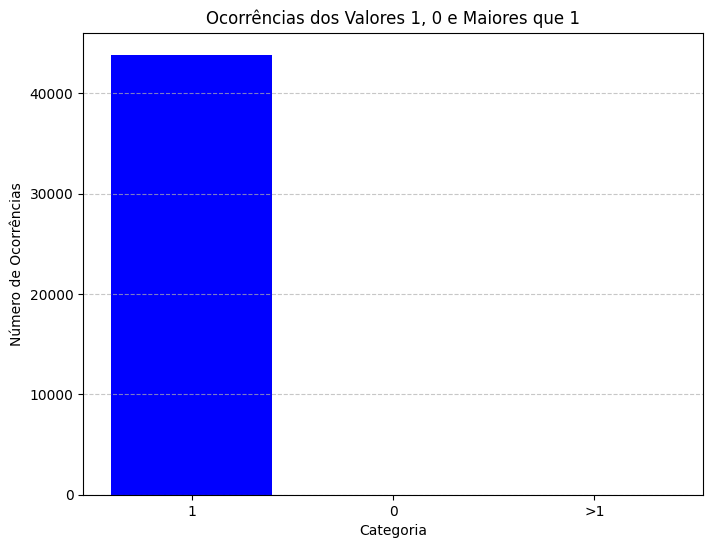

In [214]:
ocorrencias = contar_ocorrencias(resultado)

df_ocorrencias = pd.DataFrame(list(ocorrencias.items()), columns=['Categoria', 'Contagem'])

plt.figure(figsize=(8, 6))
plt.bar(df_ocorrencias['Categoria'], df_ocorrencias['Contagem'], color=['blue', 'red', 'green'])
plt.xlabel('Categoria')
plt.ylabel('Número de Ocorrências')
plt.title('Ocorrências dos Valores 1, 0 e Maiores que 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# RNN

## Label Encoder

In [215]:
label_encoder = LabelEncoder()
df_numeric['intencao_encoded'] = label_encoder.fit_transform(df_numeric['intencao'])

## Formatação de Dados Para a Rede Neural

In [216]:
grouped = df_numeric.groupby('id_sentenca').agg({
    'word_0': lambda x: list(x),
    'word_1': lambda x: list(x),
    'pos_tagging_ADJ': lambda x: list(x),
    'pos_tagging_ADP': lambda x: list(x),
    'pos_tagging_ADV': lambda x: list(x),
    'pos_tagging_AUX': lambda x: list(x),
    'pos_tagging_CCONJ': lambda x: list(x),
    'pos_tagging_DET': lambda x: list(x),
    'pos_tagging_NOUN': lambda x: list(x),
    'pos_tagging_NUM': lambda x: list(x),
    'pos_tagging_None': lambda x: list(x),
    'pos_tagging_PRON': lambda x: list(x),
    'pos_tagging_PROPN': lambda x: list(x),
    'pos_tagging_PUNCT': lambda x: list(x),
    'pos_tagging_VERB': lambda x: list(x),
    'ent_nomeada': lambda x: list(x),
    'ocorrencias': lambda x: list(x),
    'intencao_encoded': 'first'
}).reset_index()

In [217]:
vocab = list(set(word for sentence in grouped['word_0'] for word in sentence))
word_to_index = {word: i for i, word in enumerate(vocab)}

grouped['palavra_indices'] = grouped['word_0'].apply(lambda words: [word_to_index[word] for word in words])

max_length = max(len(seq) for seq in grouped['palavra_indices'])
X_words = pad_sequences(grouped['palavra_indices'], maxlen=max_length, padding='post')

In [218]:
def prepare_additional_features(grouped_df, max_length):
    features = [
        'word_1', 'pos_tagging_ADJ',
        'pos_tagging_ADP',
        'pos_tagging_ADV',
        'pos_tagging_AUX',
        'pos_tagging_CCONJ',
        'pos_tagging_DET',
        'pos_tagging_NOUN',
        'pos_tagging_NUM',
        'pos_tagging_None',
        'pos_tagging_PRON',
        'pos_tagging_PROPN',
        'pos_tagging_PUNCT',
        'pos_tagging_VERB',
        'ent_nomeada', 'ocorrencias'
    ]

    feature_arrays = []

    for feature in features:
        feature_array = pad_sequences(grouped_df[feature].tolist(), maxlen=max_length, padding='post')
        feature_arrays.append(feature_array)

    return np.stack(feature_arrays, axis=-1)

In [219]:
X_features = prepare_additional_features(grouped, max_length)
y = np.array(grouped['intencao_encoded'])

In [220]:
class AggregateFeatures(Layer):
    def __init__(self, **kwargs):
        super(AggregateFeatures, self).__init__(**kwargs)

    def call(self, inputs):
        words, features = inputs
        aggregated_features = tf.reduce_mean(features, axis=1)
        return tf.concat([words, aggregated_features], axis=-1)

## Definição do Modelo

In [221]:
vocab_size = len(vocab)
embedding_dim = 100
num_classes = len(label_encoder.classes_)
max_length = 100

X_words_padded = pad_sequences(X_words, maxlen=max_length, padding='post')
X_features_padded = pad_sequences(X_features, maxlen=max_length, padding='post')

X_train_words, X_val_words, X_train_features, X_val_features, y_train, y_val = train_test_split(
    X_words_padded, X_features_padded, y, test_size=0.2, random_state=42)

inputs_words = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs_words)

rnn_layer = Bidirectional(LSTM(units=64, return_sequences=False))(embedding_layer)
rnn_layer = Dropout(0.5)(rnn_layer)

inputs_features = Input(shape=(max_length, X_features.shape[-1]))

concat_layer = AggregateFeatures()([rnn_layer, inputs_features])

dense_layer = Dense(32, activation='relu')(concat_layer)

output_layer = Dense(num_classes, activation='softmax')(dense_layer)

model = Model(inputs=[inputs_words, inputs_features], outputs=output_layer)

## Compilação do Modelo

In [222]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Early Stop

In [223]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Treinando Modelo

In [224]:
history = model.fit(
    [X_train_words, X_train_features], y_train,
    validation_data=([X_val_words, X_val_features], y_val),
    epochs=200, batch_size=96, callbacks=[early_stopping], verbose=1
)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.0498 - loss: 3.0899 - val_accuracy: 0.0632 - val_loss: 3.0930
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0461 - loss: 3.0888 - val_accuracy: 0.0651 - val_loss: 3.0905
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0681 - loss: 3.0847 - val_accuracy: 0.0785 - val_loss: 3.0883
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0870 - loss: 3.0808 - val_accuracy: 0.1437 - val_loss: 3.0852
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1122 - loss: 3.0784 - val_accuracy: 0.1667 - val_loss: 3.0808
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1544 - loss: 3.0702 - val_accuracy: 0.1609 - val_loss: 3.0754
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1751 - loss: 3.0605 - val_accuracy: 0.1648 - val_loss: 3.0663
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1708 - loss: 3.0470 - val_accuracy: 0.

## Desempenho do modelo

Como podemos ver no gráfico abaixo, a perda de treinamento continua a diminuir enquanto a perda de validação começa a aumentar, isso é um indicativo de overfitting. O modelo está aprendendo os detalhes e ruídos dos dados de treinamento, mas não consegue generalizar para dados não vistos.

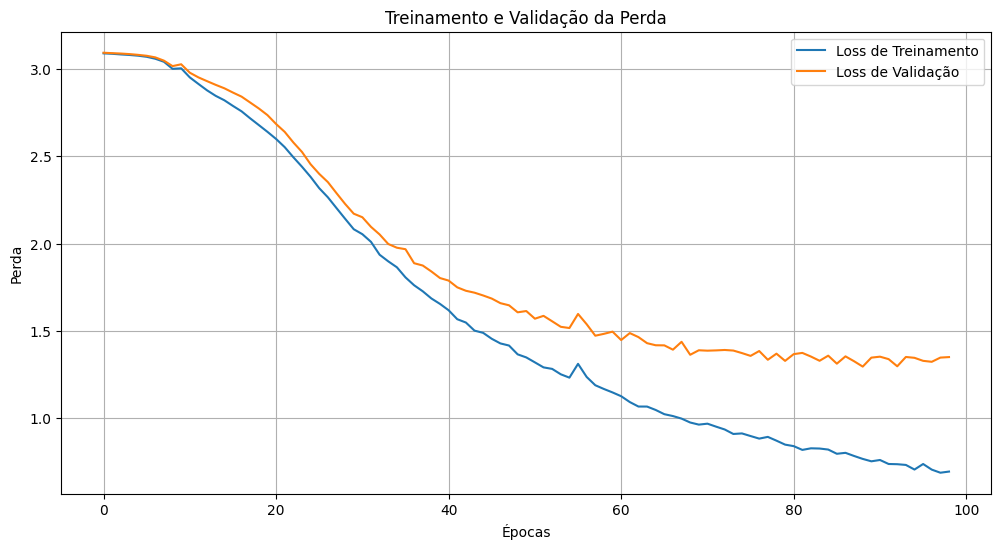

In [225]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Treinamento e Validação da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()

## Predição

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


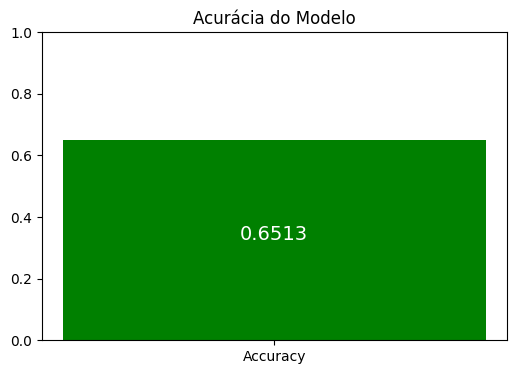

In [226]:
X_words_test_padded = pad_sequences(X_val_words, maxlen=max_length, padding='post')
X_features_test_padded = pad_sequences(X_val_features, maxlen=max_length, padding='post')

predictions = model.predict([X_words_test_padded, X_features_test_padded])
predicted_classes = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_val, predicted_classes)

plt.figure(figsize=(6, 4))
plt.title('Acurácia do Modelo')
plt.bar(['Accuracy'], [accuracy], color='green')
plt.ylim(0, 1)
plt.text(0, accuracy / 2, f'{accuracy:.4f}', ha='center', color='white', fontsize=14)
plt.show()

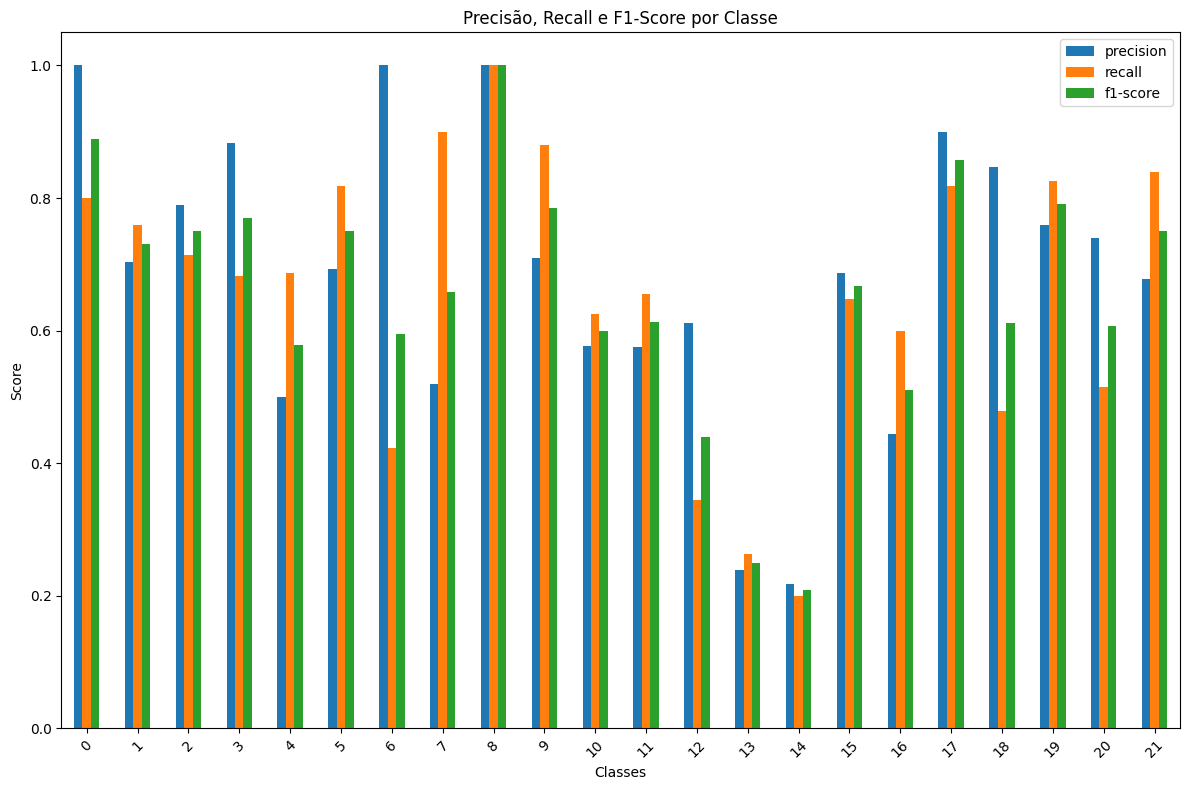

In [227]:
target_names = [str(label) for label in label_encoder.classes_]

classification_rep = classification_report(y_val, predicted_classes, target_names=target_names, output_dict=True)

metrics_df = pd.DataFrame(classification_rep).T[:-3]
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 8))
plt.title('Precisão, Recall e F1-Score por Classe')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

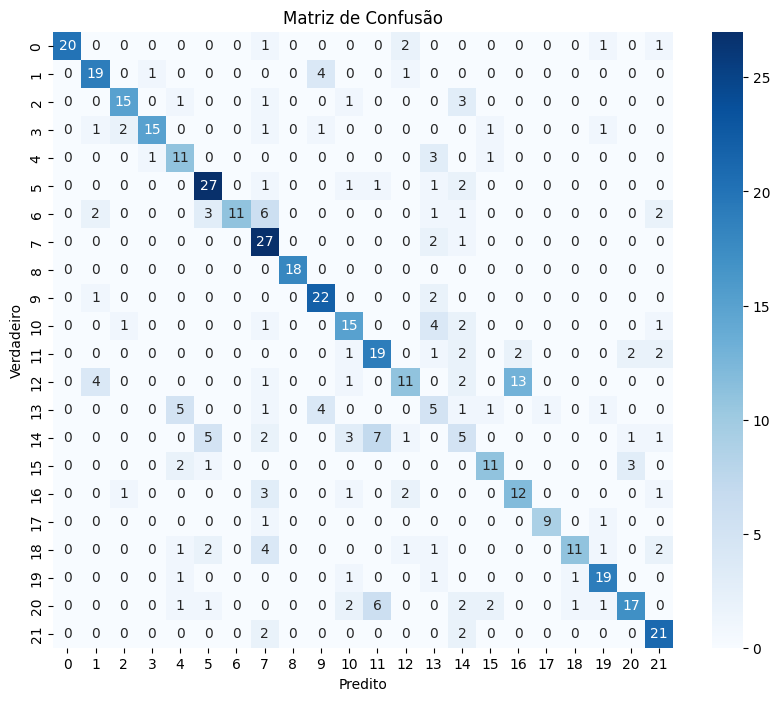

In [228]:
conf_matrix = confusion_matrix(y_val, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Save Model

In [229]:
if DOWNLOAD_MODEL:
  model.save('rnn_g1_model.h5')
  files.download('rnn_g1_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Análise da Matriz de Confusão

A matriz de confusão mostra a performance de um modelo de classificação com 19 classes (de 0 a 18). Aqui estão os principais pontos observados:

- **Precisão nas Classes**:
  - O modelo apresenta uma boa precisão em várias classes, como 0, 2, 6 e 12, onde as previsões corretas dominam a diagonal principal.

- **Confusões Comuns**:
  - Há confusões significativas entre algumas classes, especialmente:
    - Classe 0 e 1: 17 exemplos de classe 0 foram classificados como 1, e 14 exemplos de classe 1 como 0.
    - Classe 3 e 4: 10 exemplos de classe 3 foram classificados como 4.
    - Classe 14 e 15: Muitas confusões entre essas classes consecutivas.

- **Classes com Baixa Performance**:
  - Algumas classes, como 14, 16 e 18, mostram desempenho inferior, com mais confusões em relação às previsões corretas.

- **Tendências que o grupo observou**:
  - Observa-se uma tendência de confusão entre classes consecutivas, como 0 e 1, 4 e 5, 14 e 15, indicando que o modelo pode ter dificuldades para distinguir essas classes. Talvez pela ausência de dados dessa categoria no momento de treino.



# Análise de execução do modelo com GPU x CPU

Abaixo está um marcador de execução de CPU ou GPU, ao executar o modelo, é incializada uma variável de tempo até o final da execução, abaixo irá mostrar o tipo de execução se foi CPU ou GPU e o tempo total de treinamento.

Foram realizados duas execuções do modelo, segue abaixo o resultado obtido em cada um:

- CPU: 2.58 segundos
- GPU: 6.11 segundos

## Comparação de Resultados

- CPU: Teve um desempenho mais rápido, completando a tarefa em menos tempo.
- GPU: Foi mais lenta, possivelmente devido à sobrecarga de transferência de dados, inicialização ou subutilização em um modelo menor.

Apesar de a GPU normalmente ser mais rápida, neste caso, a CPU foi mais eficiente. A escolha entre CPU e GPU deve considerar o tipo de tarefa e a configuração do hardware utilizado.

In [230]:
device_name = tf.test.gpu_device_name()
if device_name:
    print("Treinado na GPU:", device_name)
else:
    print("Treinado na CPU")

Treinado na GPU: /device:GPU:0


In [231]:
elapsed_time = time.time() - start_time
print(f"Tempo total de treinamento: {elapsed_time:.2f} segundos")

Tempo total de treinamento: 66.97 segundos


### Análise do Tempo de Treinamento do Modelo

Abaixo podemos observar o tempo de treinamento do modelo RNN que foi desenvolvido utilizando CPU e GPU.

Foram feitos 3 testes de tempo do modelo, isso porque o tempo de treinamento pode variar entre execuções por vários motivos, como o uso de recursos do sistema, sobrecarga de I/O (entrada e saída de dados), variações nas alocações de memória entre outros fatores externos.

Ao realizar alguns testes conseguimos ter uma maior confiança dos resultados.

Os resultados obtidos foram:

 **1° Teste:**
Tempo de treinamento com CPU: 60.52 segundos
Tempo de treinamento com GPU: 38.38 segundos

 **2° Teste:**
Tempo de treinamento com CPU: 43.98 segundos
Tempo de treinamento com GPU: 19.06 segundos

 **3° Teste:**
Tempo de treinamento com CPU: 44.64 segundos
Tempo de treinamento com GPU: 20.27 segundos


A GPU acabou apresentando os melhores resultadose isso tem como principal razão o fato dela ser projetada para realizar um grande número de operações matemáticas em paralelo, o que é primordial para o processamento de redes neurais que envolvem muitas operações matriciais e de vetores.





### Teste 1

In [232]:
def train_and_measure_time(device):
    print(f"\nTraining with {device}...\n")
    with tf.device(device):
        start_time = time.time()
        history = model.fit(
            [X_train_words, X_train_features], y_train,
            validation_data=([X_val_words, X_val_features], y_val),
            epochs=1000, batch_size=96, callbacks=[early_stopping], verbose=1
        )
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Training time with {device}: {elapsed_time:.2f} seconds")
        return elapsed_time

cpu_time = train_and_measure_time('/CPU:0')
gpu_time = train_and_measure_time('/GPU:0')

print(f"Tempo de treinamento com CPU: {cpu_time:.2f} segundos")
print(f"Tempo de treinamento com GPU: {gpu_time:.2f} segundos")


Training with /CPU:0...

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7967 - loss: 0.7499 - val_accuracy: 0.6379 - val_loss: 1.3241
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7937 - loss: 0.7324 - val_accuracy: 0.6456 - val_loss: 1.3034
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7663 - loss: 0.7794 - val_accuracy: 0.6437 - val_loss: 1.3170
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7913 - loss: 0.7354 - val_accuracy: 0.6418 - val_loss: 1.3453
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7946 - loss: 0.7286 - val_accuracy: 0.6418 - val_loss: 1.3037
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8000 - loss: 0.7019 - val_accuracy: 0.6475 - val_loss: 1.3437
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8037 - loss: 0.7038 - val_accuracy: 0.6398 - val_loss: 1.3393
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7939

### Teste 2

In [233]:
cpu_time = train_and_measure_time('/CPU:0')
gpu_time = train_and_measure_time('/GPU:0')

print(f"Tempo de treinamento com CPU: {cpu_time:.2f} segundos")
print(f"Tempo de treinamento com GPU: {gpu_time:.2f} segundos")


Training with /CPU:0...

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7716 - loss: 0.7709 - val_accuracy: 0.6398 - val_loss: 1.3428
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7815 - loss: 0.7600 - val_accuracy: 0.6513 - val_loss: 1.3047
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8109 - loss: 0.6829 - val_accuracy: 0.6322 - val_loss: 1.3652
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7994 - loss: 0.7351 - val_accuracy: 0.6379 - val_loss: 1.3398
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7811 - loss: 0.7335 - val_accuracy: 0.6475 - val_loss: 1.3260
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7905 - loss: 0.6971 - val_accuracy: 0.6418 - val_loss: 1.3463
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7873 - loss: 0.7197 - val_accuracy: 0.6494 - val_loss: 1.3377
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8083

### Teste 3

In [234]:
cpu_time = train_and_measure_time('/CPU:0')
gpu_time = train_and_measure_time('/GPU:0')

print(f"Tempo de treinamento com CPU: {cpu_time:.2f} segundos")
print(f"Tempo de treinamento com GPU: {gpu_time:.2f} segundos")


Training with /CPU:0...

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7829 - loss: 0.7582 - val_accuracy: 0.6475 - val_loss: 1.3281
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7784 - loss: 0.7405 - val_accuracy: 0.6303 - val_loss: 1.3496
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7922 - loss: 0.7229 - val_accuracy: 0.6456 - val_loss: 1.3107
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8130 - loss: 0.6754 - val_accuracy: 0.6456 - val_loss: 1.3679
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7898 - loss: 0.7229 - val_accuracy: 0.6418 - val_loss: 1.3274
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7886 - loss: 0.7326 - val_accuracy: 0.6341 - val_loss: 1.3143
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8025 - loss: 0.6925 - val_accuracy: 0.6513 - val_loss: 1.3044
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8030